In [1]:
from google.colab import files
import pandas as pd


uploaded = files.upload()

Saving data.csv to data.csv


In [37]:
df = pd.read_csv('data.csv')

In [38]:
print(df.columns)

Index(['ad_id', 'reporting_start', 'reporting_end', 'campaign_id',
       'fb_campaign_id', 'age', 'gender', 'interest1', 'interest2',
       'interest3', 'impressions', 'clicks', 'spent', 'total_conversion',
       'approved_conversion'],
      dtype='object')


In [47]:

# Basic cleaning & type conversion
df = df.copy()


df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]

# Common column rename mapping for likely variants
rename_map = {
    'reporting_': 'reporting_start',
    'reporting_start_': 'reporting_start',
    'reporting__start': 'reporting_start',
    'impressor': 'impressions',
    'spent': 'spent',
    'clicks': 'clicks',
    'total_con': 'total_conversions',
    'approved_conversion': 'approved_conversions'
}
for k,v in rename_map.items():
    if k in df.columns and v not in df.columns:
        df = df.rename(columns={k:v})

# Ensuring the numeric columns are numeric
num_cols = ['impressions','clicks','spent','total_conversions','approved_conversions']
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)

# Parse dates if present
date_cols = [c for c in df.columns if 'reporting' in c or 'date' in c]
for c in date_cols:
    try:
        df[c] = pd.to_datetime(df[c], errors='coerce', dayfirst=True)
    except Exception:
        pass


if 'reporting_start' in df.columns and pd.api.types.is_datetime64_any_dtype(df['reporting_start']):
    df['day_of_week'] = df['reporting_start'].dt.day_name()
    df['week'] = df['reporting_start'].dt.isocalendar().week

# Removing duplicates
df = df.drop_duplicates()
print('Shape after cleaning:', df.shape)


Shape after cleaning: (1143, 28)


In [41]:
import numpy as np

# KPI computations
df['ctr'] = np.where(df['impressions']>0, df['clicks']/df['impressions'], 0)
df['cpc'] = np.where(df['clicks']>0, df['spent']/df['clicks'], np.nan)
df['cpa'] = np.where(df.get('approved_conversions', 0)>0, df['spent']/df['approved_conversions'], np.nan)

if 'revenue' in df.columns:
    df['roas'] = np.where(df['spent']>0, df['revenue']/df['spent'], np.nan)
else:

    df['roas_proxy'] = np.where(df['spent']>0, df['approved_conversions']/df['spent'], np.nan)


df['ctr_clipped'] = df['ctr'].clip(upper=df['ctr'].quantile(0.99))


kpis = {
    'total_spend': df['spent'].sum(),
    'total_clicks': int(df['clicks'].sum()),
    'total_impressions': int(df['impressions'].sum()),
    'total_approved_conversions': int(df.get('approved_conversions', pd.Series([0])).sum())
}
kpis

{'total_spend': np.float64(20114.239997279998),
 'total_clicks': 13293,
 'total_impressions': 78552672,
 'total_approved_conversions': 585}

Columns: ['ad_id', 'reporting_start', 'reporting_end', 'campaign_id', 'fb_campaign_id', 'age', 'gender', 'interest1', 'interest2', 'interest3', 'impressions', 'clicks', 'spent', 'total_conversion', 'approved_conversions', 'day_of_week', 'week', 'ctr', 'cpc', 'cpa', 'roas_proxy', 'ctr_clipped']

Missing values (top 20):
 cpa                     790
total_conversion        382
roas_proxy              354
cpc                     206
ad_id                     0
reporting_start           0
age                       0
fb_campaign_id            0
campaign_id               0
reporting_end             0
interest3                 0
gender                    0
interest2                 0
interest1                 0
spent                     0
clicks                    0
impressions               0
approved_conversions      0
ctr                       0
week                      0
dtype: int64

Descriptive stats for numeric columns:
                        count                           mean     

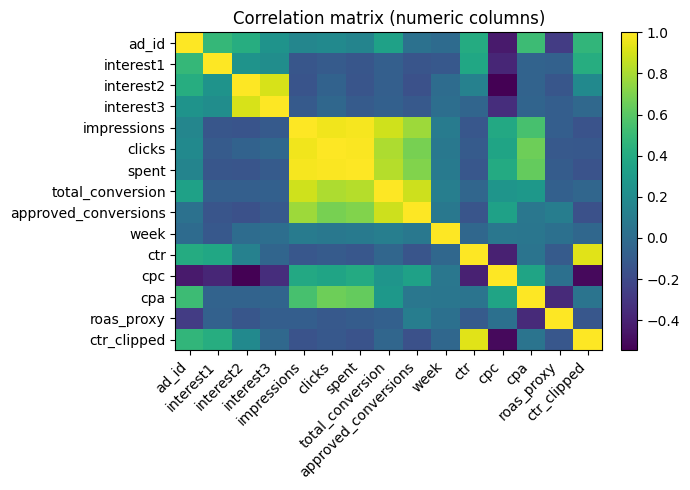

In [42]:
import matplotlib.pyplot as plt
# Exploratory Data Analysis
print('Columns:', df.columns.tolist())
print('\nMissing values (top 20):\n', df.isnull().sum().sort_values(ascending=False).head(20))
print('\nDescriptive stats for numeric columns:\n', df.describe().T[['count','mean','std','min','25%','50%','75%','max']])


num = df.select_dtypes(include=[np.number]).copy()
if not num.empty:
    corr = num.corr()
    fig, ax = plt.subplots(figsize=(7,5))
    im = ax.imshow(corr, interpolation='nearest', aspect='auto')
    ax.set_xticks(range(len(corr.columns))); ax.set_xticklabels(corr.columns, rotation=45, ha='right')
    ax.set_yticks(range(len(corr.columns))); ax.set_yticklabels(corr.columns)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title('Correlation matrix (numeric columns)')
    plt.tight_layout()
    plt.show()
else:
    print('No numeric columns available for correlation.')

,age,gender,impressions,clicks,spent,approved_conversions,ctr,cpc,cpa
157,30-34,M,3.452957e+07,4211,7391.299994,285.0,0.000122,1.755236,25.934386
169,35-39,M,1.928594e+07,2773,4822.110003,106.0,0.000144,1.738951,45.491604
173,40-44,M,1.490837e+07,2402,3960.789999,69.0,0.000161,1.648955,57.402754
174,45-49,F,3.485604e+06,973,1448.039997,25.0,0.000279,1.488222,57.921600
175,45-49,M,3.302425e+06,603,995.830003,21.0,0.000183,1.651459,47.420476
172,40-44,F,9.732190e+05,258,376.840000,13.0,0.000265,1.460620,28.987692
168,35-39,F,8.794370e+05,232,323.410001,23.0,0.000264,1.394009,14.061304
156,30-34,F,1.149027e+06,222,301.920000,43.0,0.000193,1.360000,7.021395
149,29,35,8.523200e+02,40,20.000000,0.0,0.046931,0.500000,NaN
78,16,20,1.850550e+03,55,18.000000,0.0,0.029721,0.327273,NaN


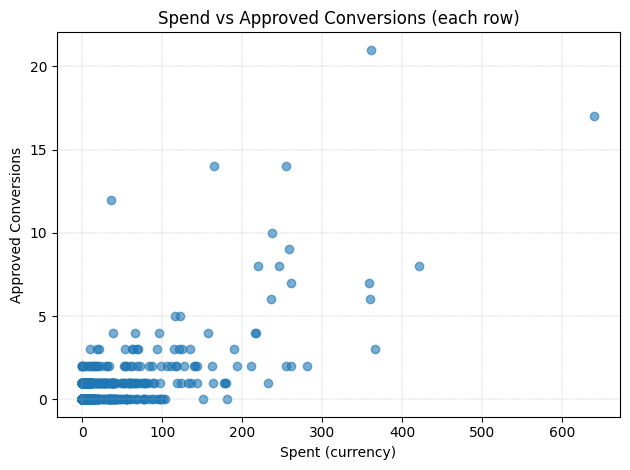

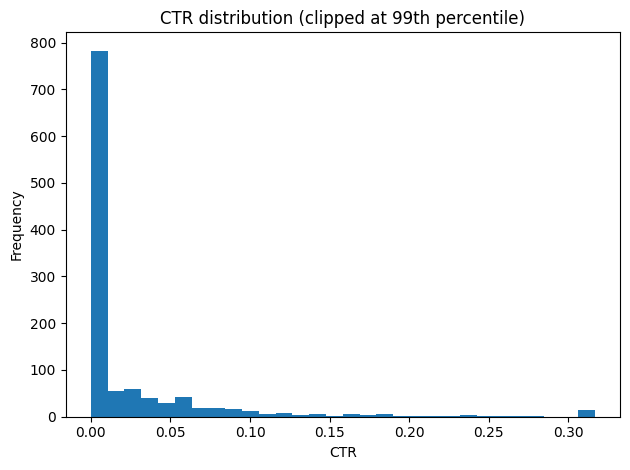

In [43]:

# Aggregations: KPI by age and gender
group_cols = [c for c in ['age','gender'] if c in df.columns]
if group_cols:
    agg = df.groupby(group_cols).agg(
        impressions=('impressions','sum'),
        clicks=('clicks','sum'),
        spent=('spent','sum'),
        approved_conversions=('approved_conversions','sum')
    ).reset_index()
    agg['ctr'] = np.where(agg['impressions']>0, agg['clicks']/agg['impressions'], 0)
    agg['cpc'] = np.where(agg['clicks']>0, agg['spent']/agg['clicks'], np.nan)
    agg['cpa'] = np.where(agg['approved_conversions']>0, agg['spent']/agg['approved_conversions'], np.nan)

    display(agg.sort_values('spent', ascending=False).head(10))
else:
    print('No age/gender columns to aggregate.')


# 1) Spend vs Approved Conversions (scatter)
if 'spent' in df.columns and 'approved_conversions' in df.columns:
    fig, ax = plt.subplots()
    ax.scatter(df['spent'], df['approved_conversions'], alpha=0.6)
    ax.set_xlabel('Spent (currency)'); ax.set_ylabel('Approved Conversions')
    ax.set_title('Spend vs Approved Conversions (each row)')
    plt.grid(True, linestyle='--', linewidth=0.3)
    plt.tight_layout()
    plt.show()

# 2) CTR distribution (histogram)
if 'ctr' in df.columns:
    fig, ax = plt.subplots()
    ax.hist(df['ctr_clipped'].dropna(), bins=30)
    ax.set_title('CTR distribution (clipped at 99th percentile)')
    ax.set_xlabel('CTR'); ax.set_ylabel('Frequency')
    plt.tight_layout()
    plt.show()


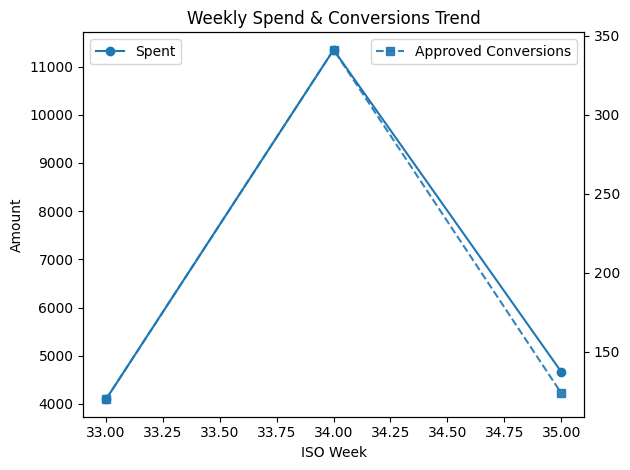

In [44]:
# Week-level trend
if 'week' in df.columns:
    weekly = df.groupby('week').agg(spent=('spent','sum'), approved_conversions=('approved_conversions','sum')).reset_index()
    fig, ax = plt.subplots()
    ax.plot(weekly['week'], weekly['spent'], marker='o', label='Spent')
    ax.set_xlabel('ISO Week'); ax.set_ylabel('Amount')
    ax2 = ax.twinx()
    ax2.plot(weekly['week'], weekly['approved_conversions'], marker='s', linestyle='--', label='Approved Conversions', alpha=0.9)
    ax.set_title('Weekly Spend & Conversions Trend')
    ax.legend(loc='upper left'); ax2.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
else:
    print('No reporting date to generate week-level trend.')

In [45]:
import numpy as np

df['ROAS'] = df['approved_conversions'] / df['spent']

# Click Through Rate (CTR): Ad Quality/Engagement metric
df['CTR'] = df['clicks'] / df['impressions']


df['CPC'] = df['spent'] / df['clicks'].replace(0, np.nan)

# Cost Per Acquisition (CPA): Acquisition efficiency metric

df['CPA'] = df['spent'] / df['approved_conversions'].replace(0, np.nan)



df['DayOfWeek'] = pd.to_datetime(df['reporting_start']).dt.day_name()
df['Week_Number'] = pd.to_datetime(df['reporting_start']).dt.isocalendar().week.astype(int)

print("--- KPI Calculation Complete ---")
print(f"ROAS Check (Mean): {df['ROAS'].mean():.2f}")

--- KPI Calculation Complete ---
ROAS Check (Mean): inf


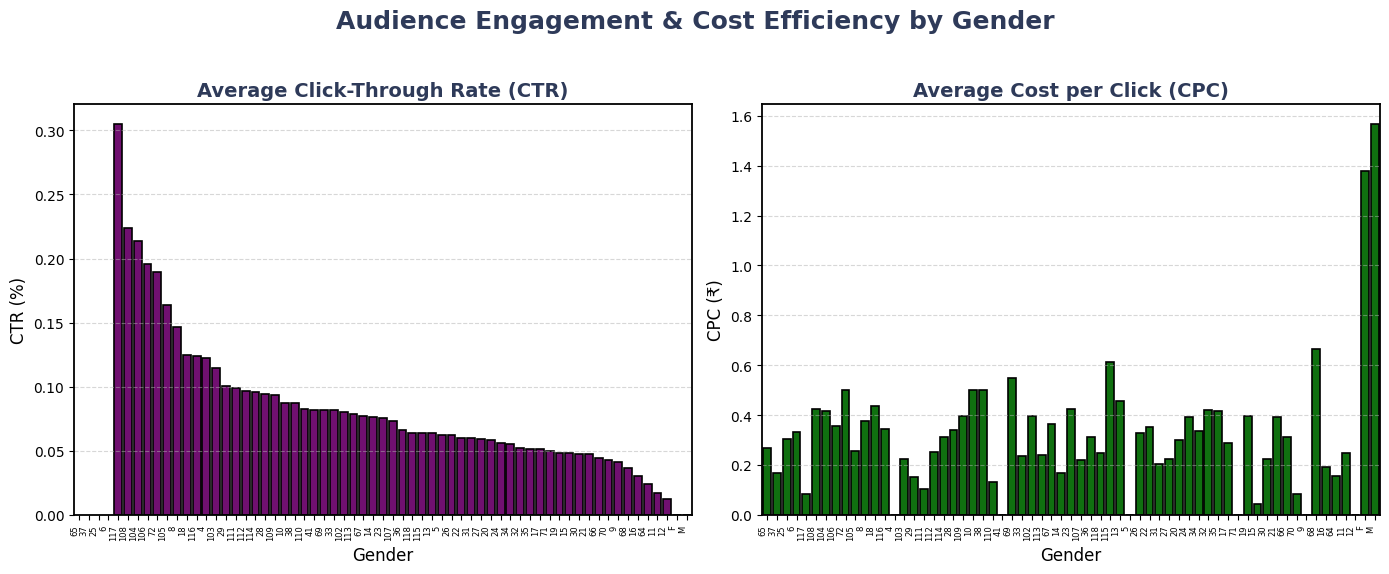

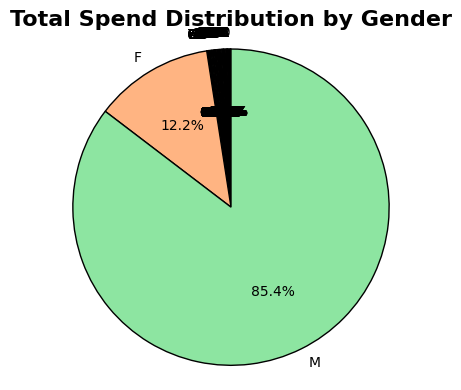

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

def add_plot_outline(ax):
    """Adds a sleek outline around the plot area"""
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor('black')
        spine.set_linewidth(1.3)

# Aggregation: Average CTR and CPC by Gender
gender_metrics = df.groupby('gender').agg(
    Avg_CTR=('CTR', 'mean'),
    Avg_CPC=('CPC', 'mean')
).reset_index().sort_values(by='Avg_CTR', ascending=False)

# Dashboard: Audience Engagement & Cost Efficiency
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Audience Engagement & Cost Efficiency by Gender',
             fontsize=18, fontweight='bold', color='#2E3A59')

#  CTR by Gender
sns.barplot(
    x='gender', y='Avg_CTR', data=gender_metrics,
    color='purple', edgecolor='black', linewidth=1.2, ax=axes[0]
)
axes[0].set_title('Average Click-Through Rate (CTR)', fontsize=14, fontweight='bold', color='#2E3A59')
axes[0].set_xlabel('Gender', fontsize=12)
axes[0].set_ylabel('CTR (%)', fontsize=12)

axes[0].grid(axis='y', linestyle='--', alpha=0.5)
add_plot_outline(axes[0])
plt.setp(axes[0].get_xticklabels(), rotation=90, ha='right',fontsize=6)



# CPC by Gender
sns.barplot(
    x='gender', y='Avg_CPC', data=gender_metrics,
    color='green', edgecolor='black', linewidth=1.2, ax=axes[1]
)
axes[1].set_title('Average Cost per Click (CPC)', fontsize=14, fontweight='bold', color='#2E3A59')
axes[1].set_xlabel('Gender', fontsize=12)
axes[1].set_ylabel('CPC (₹)', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.5)
add_plot_outline(axes[1])
plt.setp(axes[1].get_xticklabels(), rotation=90, ha='right',fontsize=6)




plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
# Total Spend Distribution by Gender (Pie Chart)
plt.figure(figsize=(4,4))

# 2. Spend Distribution by Gender (Budget Allocation Check)
gender_spend = df.groupby('gender')['spent'].sum()
plt.pie(gender_spend, labels=gender_spend.index, autopct='%1.1f%%',
        startangle=90, colors=sns.color_palette('pastel'),
        wedgeprops={'edgecolor': 'black', 'linewidth': 1.0})
plt.title('Total Spend Distribution by Gender', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()
